# **Image Classification**

In [1]:
# importing the essiential libraries

import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# loading the dataset from kaggle directly around 10000 images

!kaggle datasets download -d tongpython/cat-and-dog


Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 99% 215M/218M [00:11<00:00, 22.4MB/s]
100% 218M/218M [00:11<00:00, 19.7MB/s]


In [3]:
# Unzip the folder

import zipfile

with zipfile.ZipFile('/content/cat-and-dog.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [4]:
# Load the Images dataset from colab
import os

train_dir = "/content/training_set/training_set"
test_dir = "/content/test_set/test_set"

# Check the number of images in each subfolder
def count_images(directory):
    categories = os.listdir(directory)  # List of categories (e.g., cats, dogs)
    for category in categories:
        category_path = os.path.join(directory, category)
        num_images = len(os.listdir(category_path))
        print(f"Number of images in {category}: {num_images}")

print("Training Set:")
count_images(train_dir)

print("\nTest Set:")
count_images(test_dir)


Training Set:
Number of images in dogs: 4006
Number of images in cats: 4001

Test Set:
Number of images in dogs: 1013
Number of images in cats: 1012


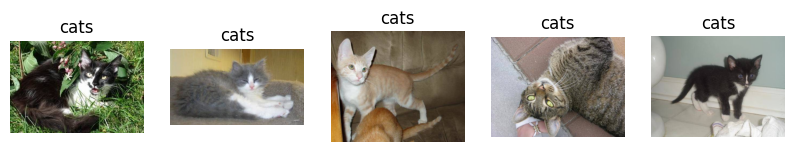

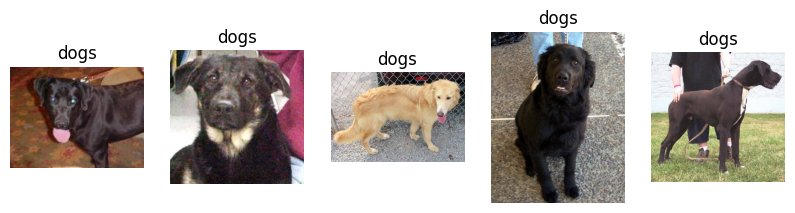

In [5]:
# checking the image data

def show_sample_images(directory, category, num_images=5):
    category_path = os.path.join(directory, category)
    images = os.listdir(category_path)[:num_images]  # Get a few images

    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Display 5 images from the 'cats' and 'dogs' categories in the training set
show_sample_images(train_dir, 'cats')
show_sample_images(train_dir, 'dogs')




In [6]:
# Preprocess the data

# Define the image data generator with preprocessing and augmentation
# Data preparation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test sets, usually only rescaling is needed
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
# Path to your dataset

train_generator = train_datagen.flow_from_directory(
    '/content/training_set/training_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/test_set/test_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)



Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [8]:
# Check number of samples
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", test_generator.samples)

Number of training samples: 8005
Number of validation samples: 2023


In [9]:
# Load ResNet50 with ImageNet weights, exclude the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
# Model setup
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

In [11]:
# compile the model

# Adjust learning rate
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



In [12]:
# Callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [13]:
# Dealing with warnings

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')


In [14]:
# Creating Hyperparameter parameters

batch_size = 32
steps_per_epoch = 8005 // batch_size
validation_steps = 2023 // batch_size


In [15]:
# setting the steps & epochs.

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = test_generator.samples // test_generator.batch_size

# Ensure these values are not zero
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)


In [16]:
def preprocess_image(image, label):
    # Resize and normalize image
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label


def load_dataset(directory, batch_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(224, 224),
        batch_size=batch_size,
        label_mode='binary'  # Adjust this based on your classification problem
    )
    dataset = dataset.map(preprocess_image)
    return dataset

In [17]:
train_dataset = load_dataset('/content/training_set/training_set', batch_size=32)
validation_dataset = load_dataset('/content/test_set/test_set', batch_size=32)

train_dataset = train_dataset.batch(32).repeat()
validation_dataset = validation_dataset.batch(32).repeat()

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [18]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 657ms/step - accuracy: 0.8917 - loss: 8.2310 - val_accuracy: 0.5154 - val_loss: 4.8649 - learning_rate: 1.0000e-04
Epoch 2/10
  1/250 ━━━━━━━━━━━━━━━━━━━━ 1:19 317ms/step - accuracy: 0.8438 - loss: 4.4224

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8438 - loss: 4.4224 - val_accuracy: 0.7143 - val_loss: 4.8010 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 566ms/step - accuracy: 0.9670 - loss: 3.6773 - val_accuracy: 0.5079 - val_loss: 3.0631 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.3439 - val_accuracy: 0.7143 - val_loss: 3.0033 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 575ms/step - accuracy: 0.9750 - loss: 2.0888 - val_accuracy: 0.9430 - val_loss: 1.5094 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - accuracy: 0.9375 - loss: 1.5200 - val_accuracy: 0.8571 - val_loss: 1.6690 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 189s 524ms/step - accuracy: 0.9818 - loss: 1.2491 - val_accuracy: 0.9727 - val_loss: 0.9427 - learning_rate: 1.0000e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - accu

In [19]:
# Extract accuracy and loss from history



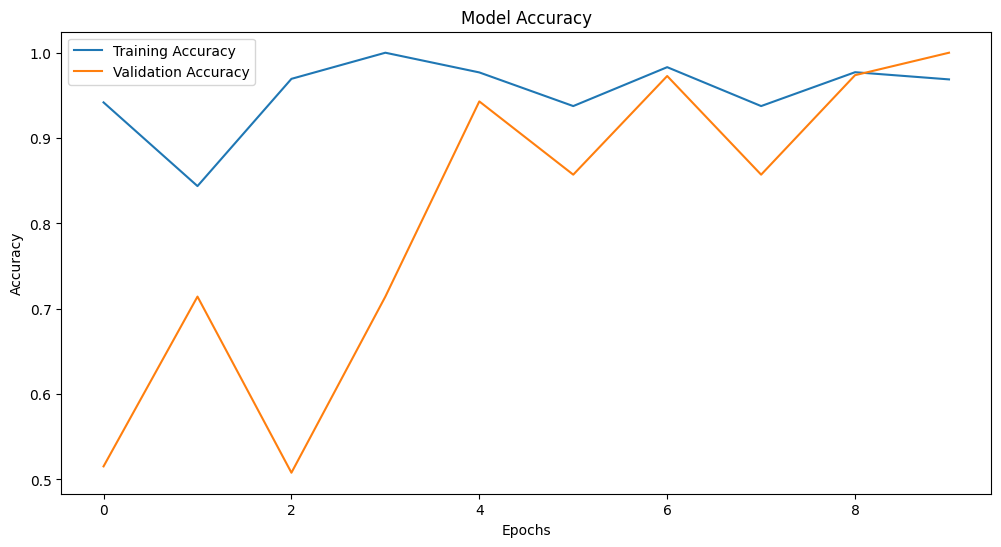

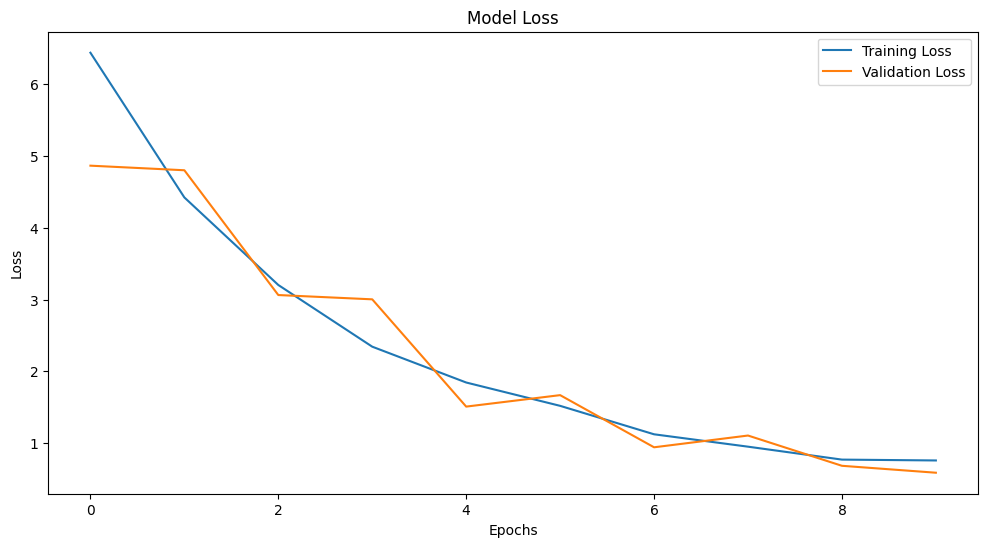

In [28]:
# Plot accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.plot(accuracy, label='Training Accuracy')

# Plot validation accuracy
plt.plot(val_accuracy, label='Validation Accuracy')
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Add titles and labels
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9710 - loss: 0.7079
Test Accuracy: 97.28%


In [22]:
model.save('my_model.h5')


In [23]:
from tensorflow.keras.models import load_model

model = load_model('my_model.h5')


In [24]:
import requests
from io import BytesIO
from PIL import Image

def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to match model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize
    return img_array

In [26]:
def predict_image(url):
    img = download_image(url)
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    # Assuming binary classification
    class_label = 'Dog' if predictions[0] > 0.5 else 'Cat'
    return class_label



In [39]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: Cat


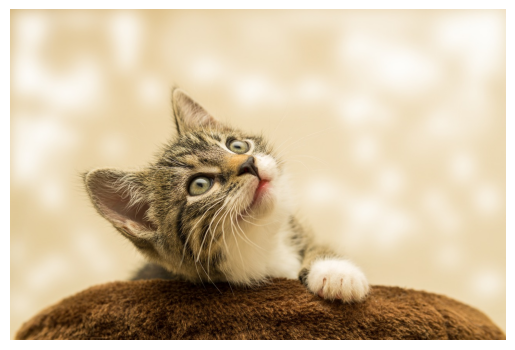

In [40]:
# Test with an image URL
url = 'https://cdn.pixabay.com/photo/2019/11/08/11/56/kitten-4611189_1280.jpg'
prediction = predict_image(url)

# Step 1: Fetch the image from the URL
response = requests.get(url)

# Step 2: Open the image using PIL from the downloaded bytes
img = Image.open(BytesIO(response.content))

# Step 3: Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # To hide the axis
plt

print(f'Prediction: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: Dog


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

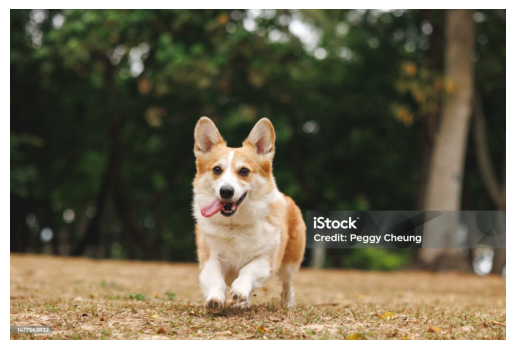

In [41]:
# Test with an image URL
url = 'https://media.istockphoto.com/id/1477563832/photo/happy-energetic-pet-corgi-dog-running-on-grass-in-a-nature-park-outdoors-having-fun-playing.jpg?s=1024x1024&w=is&k=20&c=fsq8ebTxQrI1loa02HvW70cQKIywpl-XDQ0QDz0ZPRg='
prediction = predict_image(url)
print(f'Prediction: {prediction}')

# Step 1: Fetch the image from the URL
response = requests.get(url)

# Step 2: Open the image using PIL from the downloaded bytes
img = Image.open(BytesIO(response.content))

# Step 3: Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # To hide the axis
plt




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Dog


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

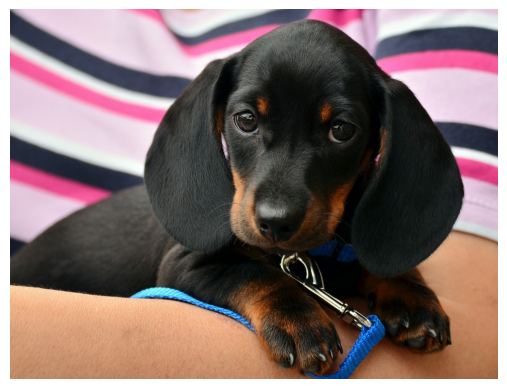

In [38]:
# Test with an image URL
url = 'https://cdn.pixabay.com/photo/2016/07/15/15/55/dachshund-1519374_1280.jpg'

prediction = predict_image(url)
print(f'Prediction: {prediction}')

# Step 1: Fetch the image from the URL
response = requests.get(url)

# Step 2: Open the image using PIL from the downloaded bytes
img = Image.open(BytesIO(response.content))

# Step 3: Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # To hide the axis
plt

